In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
%matplotlib inline
plt.rc('font',family='Malgun Gothic')

In [2]:
# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# 주어진 데이터 탐색 및 전처리

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [6]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [7]:
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

In [8]:
train["년"] = pd.DatetimeIndex(train["일자"]).year
train["월"] = pd.DatetimeIndex(train["일자"]).month
train["일"] = pd.DatetimeIndex(train["일자"]).day
test["월"] = pd.DatetimeIndex(test["일자"]).month
test["일"] = pd.DatetimeIndex(test["일자"]).day

In [9]:
train["식사가능인원"] = train["본사정원수"] - train["본사휴가자수"] - train["현본사소속재택근무자수"]
# train["중식식사비율"] = (train["중식계"] / train["식사가능인원"])*100
# train["석식식사비율"] = (train["석식계"] / train["식사가능인원"])*100

test["식사가능인원"] = test["본사정원수"] - test["본사휴가자수"] - test["현본사소속재택근무자수"]
# test["중식계"] = train["중식계"]
# test["석식계"] = train["석식계"]
# test["중식식사비율"] = (test["중식계"] / test["식사가능인원"])*100
# test["석식식사비율"] = (test["석식계"] / test["식사가능인원"])*100

- 비율은 큰 의미가 없음 그래프를 통해서도 알수 있지만 필요없는 속성값
- test 파일에 필요한 값으로 들어가지 않는다! (train은 0~9까지라면 test는 0, 4, 7, 3, 이런 순서로 되어있다.)

In [10]:
train.drop(["일자", "조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace=False)

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,년,월,일,식사가능인원
0,0,2601,50,150,238,0.0,1039.0,331.0,2016,2,1,2551.0
1,1,2601,50,173,319,0.0,867.0,560.0,2016,2,2,2551.0
2,2,2601,56,180,111,0.0,1017.0,573.0,2016,2,3,2545.0
3,3,2601,104,220,355,0.0,978.0,525.0,2016,2,4,2497.0
4,4,2601,278,181,34,0.0,925.0,330.0,2016,2,5,2323.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2,2983,75,198,4,391.0,1093.0,421.0,2021,1,20,2517.0
1201,3,2983,92,231,462,351.0,832.0,353.0,2021,1,21,2540.0
1202,4,2983,255,248,1,303.0,579.0,217.0,2021,1,22,2425.0
1203,0,2983,107,153,616,327.0,1145.0,502.0,2021,1,25,2549.0


In [11]:
year_mean = train.groupby("년").mean()[["중식계", "석식계", "현본사소속재택근무자수", "본사시간외근무명령서승인건수"]]

In [12]:
year_mean

,중식계,석식계,현본사소속재택근무자수,본사시간외근무명령서승인건수
년,,,,
2016,932.792952,519.418502,0.000000,229.013216
2017,897.614754,457.049180,0.000000,236.782787
2018,882.903766,463.539749,0.000000,239.732218
2019,850.512195,445.386179,0.000000,307.626016
2020,882.267241,430.668103,198.836207,353.995690
2021,1009.705882,396.588235,370.294118,320.647059


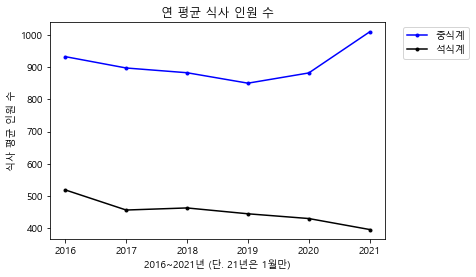

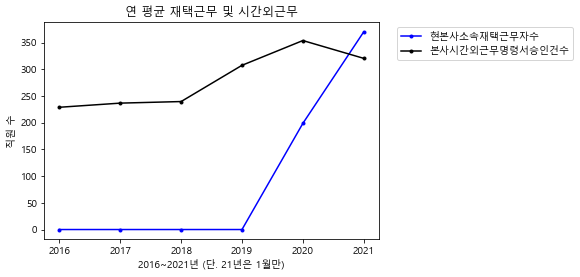

In [13]:
x = ["2016", "2017", "2018", "2019", "2020", "2021"]

plt.subplots()
plt.plot(x, year_mean["중식계"], marker='.', color='blue', label="중식계")
plt.plot(x, year_mean["석식계"], marker='.', color='black', label="석식계")
plt.xlabel("2016~2021년 (단. 21년은 1월만)")
plt.ylabel("식사 평균 인원 수")
plt.title("연 평균 식사 인원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.subplots()
plt.plot(x, year_mean["현본사소속재택근무자수"], marker='.', color='blue', label="현본사소속재택근무자수")
plt.plot(x, year_mean["본사시간외근무명령서승인건수"], marker='.', color='black', label="본사시간외근무명령서승인건수")
plt.xlabel("2016~2021년 (단. 21년은 1월만)")
plt.ylabel("직원 수")
plt.title("연 평균 재택근무 및 시간외근무")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

In [14]:
month_mean = train.groupby("월").mean()[["중식계", "석식계"]]

In [15]:
month_mean

,중식계,석식계
월,,
1,934.247525,424.564356
2,989.623656,514.860215
3,953.607477,530.700935
4,883.621359,480.825243
5,869.787879,458.131313
6,863.311111,460.355556
7,848.736364,437.300000
8,854.785047,459.485981
9,907.148936,463.617021


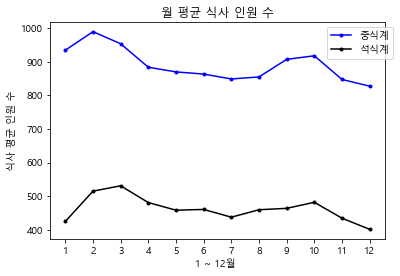

In [16]:
x = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

plt.subplots()
plt.plot(x, month_mean["중식계"], marker='.', color='blue', label="중식계")
plt.plot(x, month_mean["석식계"], marker='.', color='black', label="석식계")
plt.xlabel("1 ~ 12월 ")
plt.ylabel("식사 평균 인원 수")
plt.title("월 평균 식사 인원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

In [17]:
week_mean = train.groupby("요일").mean()[["중식계", "석식계"]]

In [18]:
week_mean

,중식계,석식계
요일,,
0,1144.331950,538.933610
1,925.620833,520.129167
2,905.213389,363.615063
3,823.991803,480.401639
4,653.609959,404.979253


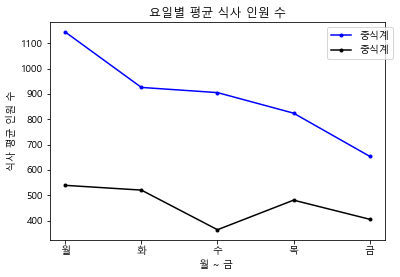

In [19]:
x = ["월", "화", "수", "목", "금"]
plt.subplots()
plt.plot(x, week_mean["중식계"], marker='.', color='blue', label="중식계")
plt.plot(x, week_mean["석식계"], marker='.', color='black', label="중식계")
plt.xlabel("월 ~ 금 ")
plt.ylabel("식사 평균 인원 수")
plt.title("요일별 평균 식사 인원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

In [20]:
employee_week = train.groupby("요일").mean()[["본사정원수", "식사가능인원"]]

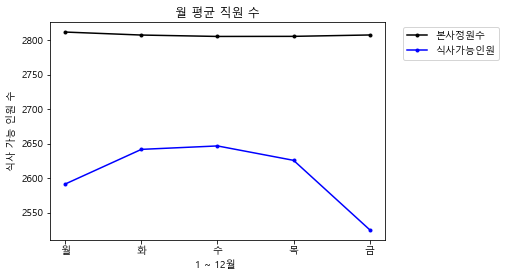

In [21]:
x1 = ["월", "화", "수", "목", "금"]
plt.subplots()
plt.plot(x1, employee_week["본사정원수"], marker='.', color='black', label="본사정원수")
plt.plot(x1, employee_week["식사가능인원"], marker='.', color='blue', label="식사가능인원")
plt.xlabel("1 ~ 12월 ")
plt.ylabel("식사 가능 인원 수")
plt.title("월 평균 직원 수")
plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

# 메뉴 데이터 탐색 및 전처리

In [22]:
bistro_train = train[['석식메뉴', '중식메뉴', "조식메뉴"]]
bistro_test = test[['석식메뉴', '중식메뉴', "조식메뉴"]]

In [28]:
lunch_train = []
for i, feature in enumerate(bistro_train["중식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    lunch_train.append(re.split(" ", a))

In [29]:
lunch_test = []
for i, feature in enumerate(bistro_test["중식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    lunch_test.append(re.split(" ", a))

In [30]:
dinner_train = []
for i, feature in enumerate(bistro_train["석식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    dinner_train.append(re.split(" ", a))
dinner_train[19:21]

[['멸치주먹밥', '우동', '떡볶이', '군고구마', '단무지', '포기김치'],
 ['쌀밥/잡곡밥', '오징어국', '미트볼조림', '옥수수전', '부추생채', '포기김치']]

In [31]:
dinner_test = []
for i, feature in enumerate(bistro_test["석식메뉴"]):
    a = re.sub("\(.*?\)", "", feature).strip(" ")
    a = re.sub("  ", " ", a)
    dinner_test.append(re.split(" ", a))
dinner_test[19:21]

[['흑미밥', '계란파국', '쭈꾸미불고기', '모둠채소전*장', '씨앗콩자반', '포기김치'],
 ['흑미밥', '스팸김치찌개', '삼치구이*와사비장', '브로콜리깨소스무침', '연근조림', '포기김치']]

In [32]:
import pandas as pd

col = ["lunch_rice_train", "lunch_soup_train", "lunch_main1_train", "lunch_main2_train", "lunch_main3_train", 
       "lunch_dessert_train", "lunch_Sd1_train", "lunch_Sd2_train"]
lunch_menu_train = pd.DataFrame(lunch_train, columns=col)
lunch_menu_train.fillna("없음", inplace=True)

In [33]:
import pandas as pd

col = ["lunch_rice_test", "lunch_soup_test", "lunch_main1_test", "lunch_main2_test", "lunch_main3_test", 
       "lunch_dessert_test", "lunch_Sd1_test"]
lunch_menu_test = pd.DataFrame(lunch_test, columns=col)
lunch_menu_test.fillna("없음", inplace=True)

In [34]:
import pandas as pd

col = ["dinner_rice_train", "dinner_soup_train", "dinner_main1_train", "dinner_main2_train", "dinner_main3_train", 
       "dinner_dessert_train", "dinner_Sd1_train", "dinner_Sd2_train"]
dinner_menu_train = pd.DataFrame(dinner_train, columns=col)
dinner_menu_train.fillna("없음", inplace=True)

In [35]:
import pandas as pd

col = ["dinner_rice_test", "dinner_soup_test", "dinner_main1_test", "dinner_main2_test", "dinner_main3_test", 
       "dinner_dessert_test", "dinner_Sd1_test"]
dinner_menu_test = pd.DataFrame(dinner_test, columns=col)
dinner_menu_test.fillna("없음", inplace=True)

In [36]:
lrtc =[]
for i in lunch_menu_train["lunch_rice_train"]:
    lrtc.append(i.split("/"))
    
lrtec =[]
for i in lunch_menu_test["lunch_rice_test"]:
    lrtec.append(i.split("/"))
    
drtc =[]
for i in dinner_menu_train["dinner_rice_train"]:
    drtc.append(i.split("/"))
    
drtec =[]
for i in dinner_menu_test["dinner_rice_test"]:
    drtec.append(i.split("/"))

In [37]:
lunch_rice_train_cnt =[]
lunch_rice_test_cnt =[]
dinner_rice_train_cnt =[]
dinner_rice_test_cnt =[]

In [38]:
for i in range(len(lrtc)):
    if len(lrtc[i]) == 1:
        lunch_rice_train_cnt.append(1)
    elif len(lrtc[i]) == 2:
        lunch_rice_train_cnt.append(2)
    elif len(lrtc[i]) == 3:
        lunch_rice_train_cnt.append(3)
        
for i in range(len(lrtec)):
    if len(lrtec[i]) == 1:
        lunch_rice_test_cnt.append(1)
    elif len(lrtec[i]) == 2:
        lunch_rice_test_cnt.append(2)
    elif len(lrtec[i]) == 3:
        lunch_rice_test_cnt.append(3)

for i in range(len(drtc)):
    if len(drtc[i]) == 1:
        dinner_rice_train_cnt.append(1)
    elif len(drtc[i]) == 2:
        dinner_rice_train_cnt.append(2)
    elif len(drtc[i]) == 3:
        dinner_rice_train_cnt.append(3)

for i in range(len(drtec)):
    if len(drtec[i]) == 1:
        dinner_rice_test_cnt.append(1)
    elif len(drtec[i]) == 2:
        dinner_rice_test_cnt.append(2)
    elif len(drtec[i]) == 3:
        dinner_rice_test_cnt.append(3)

In [39]:
lunch_rice_train = []
lunch_rice_test = []
dinner_rice_train = []
dinner_rice_test = []

In [40]:
for i in lunch_menu_train["lunch_rice_train"]:
    if re.search("볶음", i):
        lunch_rice_train.append("볶음밥")
    elif re.search("카레", i):
        lunch_rice_train.append("덮밥")
    elif re.search("장밥", i):
        lunch_rice_train.append("덮밥")
    elif re.search("덮밥", i):
        lunch_rice_train.append("덮밥")
    elif re.search("라이스", i):
        lunch_rice_train.append("덮밥")
    elif re.search("특식", i):
        lunch_rice_train.append("찹쌀밥")
    elif re.search("곤드레", i):
        lunch_rice_train.append("곤드레")
    elif re.search("미밥", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("오곡밥", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("잡곡", i):
        lunch_rice_train.append("잡곡밥")
    elif re.search("영양", i):
        lunch_rice_train.append("비빔밥")
    elif re.search("콩나물", i):
        lunch_rice_train.append("비빔밥")
    elif re.search("비빔", i):
        lunch_rice_train.append("비빔밥")
    else : 
        lunch_rice_train.append("특별식")
        
for i in lunch_menu_test["lunch_rice_test"]:
    if re.search("볶음", i):
        lunch_rice_test.append("볶음밥")
    elif re.search("카레", i):
        lunch_rice_test.append("덮밥")
    elif re.search("장밥", i):
        lunch_rice_test.append("덮밥")
    elif re.search("덮밥", i):
        lunch_rice_test.append("덮밥")
    elif re.search("라이스", i):
        lunch_rice_test.append("덮밥")
    elif re.search("특식", i):
        lunch_rice_test.append("찹쌀밥")
    elif re.search("곤드레", i):
        lunch_rice_test.append("곤드레")
    elif re.search("미밥", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("오곡밥", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("잡곡", i):
        lunch_rice_test.append("잡곡밥")
    elif re.search("영양", i):
        lunch_rice_test.append("비빔밥")
    elif re.search("콩나물", i):
        lunch_rice_test.append("비빔밥")
    elif re.search("비빔", i):
        lunch_rice_test.append("비빔밥")
    else : 
        lunch_rice_test.append("특별식")
        
for i in dinner_menu_train["dinner_rice_train"]:
    if re.search("볶음", i):
        dinner_rice_train.append("볶음밥")
    elif re.search("카레", i):
        dinner_rice_train.append("덮밥")
    elif re.search("장밥", i):
        dinner_rice_train.append("덮밥")
    elif re.search("덮밥", i):
        dinner_rice_train.append("덮밥")
    elif re.search("라이스", i):
        dinner_rice_train.append("덮밥")
    elif re.search("특식", i):
        dinner_rice_train.append("찹쌀밥")
    elif re.search("곤드레", i):
        dinner_rice_train.append("곤드레")
    elif re.search("미밥", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("오곡밥", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("잡곡", i):
        dinner_rice_train.append("잡곡밥")
    elif re.search("영양", i):
        dinner_rice_train.append("비빔밥")
    elif re.search("콩나물", i):
        dinner_rice_train.append("비빔밥")
    elif re.search("비빔", i):
        dinner_rice_train.append("비빔밥")
    elif re.search("초밥", i):
        dinner_rice_train.append("초밥")
    elif re.search("주먹", i):
        dinner_rice_train.append("주먹밥")
    elif re.search("김밥", i):
        dinner_rice_train.append("김밥")
    elif re.search("냉면", i):
        dinner_rice_train.append("면류")
    elif re.search("스파게티", i):
        dinner_rice_train.append("면류")
    elif re.search("콩국수", i):
        dinner_rice_train.append("면류")
    elif re.search("면", i):
        dinner_rice_train.append("면류")
    else : 
        dinner_rice_train.append("특별식")
        
for i in dinner_menu_test["dinner_rice_test"]:
    if re.search("볶음", i):
        dinner_rice_test.append("볶음밥")
    elif re.search("카레", i):
        dinner_rice_test.append("덮밥")
    elif re.search("장밥", i):
        dinner_rice_test.append("덮밥")
    elif re.search("덮밥", i):
        dinner_rice_test.append("덮밥")
    elif re.search("라이스", i):
        dinner_rice_test.append("덮밥")
    elif re.search("특식", i):
        dinner_rice_test.append("찹쌀밥")
    elif re.search("곤드레", i):
        dinner_rice_test.append("곤드레")
    elif re.search("미밥", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("오곡밥", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("잡곡", i):
        dinner_rice_test.append("잡곡밥")
    elif re.search("영양", i):
        dinner_rice_test.append("비빔밥")
    elif re.search("콩나물", i):
        dinner_rice_test.append("비빔밥")
    elif re.search("비빔", i):
        dinner_rice_test.append("비빔밥")
    elif re.search("초밥", i):
        dinner_rice_test.append("초밥")
    elif re.search("주먹", i):
        dinner_rice_test.append("주먹밥")
    elif re.search("김밥", i):
        dinner_rice_test.append("김밥")
    elif re.search("냉면", i):
        dinner_rice_test.append("면류")
    elif re.search("스파게티", i):
        dinner_rice_test.append("면류")
    elif re.search("콩국수", i):
        dinner_rice_test.append("면류")
    elif re.search("면", i):
        dinner_rice_test.append("면류")
    else : 
        dinner_rice_test.append("특별식")

In [41]:
lunch_soup_train = []
lunch_soup_test = []
dinner_soup_train = []
dinner_soup_test = []

In [42]:
for i in lunch_menu_train["lunch_soup_train"]:
    if re.search("찌개", i):
        lunch_soup_train.append("찌개류")
    elif re.search("삼계", i):
        lunch_soup_train.append("삼계탕")
    elif re.search("백숙", i):
        lunch_soup_train.append("삼계탕")
    elif re.search("탕", i):
        lunch_soup_train.append("탕류")
    elif re.search("짬뽕", i):
        lunch_soup_train.append("면류")
    elif re.search("우동", i):
        lunch_soup_train.append("면류")
    elif re.search("국수", i):
        lunch_soup_train.append("면류")
    elif re.search("칼국", i):
        lunch_soup_train.append("밀가루")
    elif re.search("제비", i):
        lunch_soup_train.append("밀가루")
    elif re.search("떡", i):
        lunch_soup_train.append("밀가루")
    elif re.search("만두", i):
        lunch_soup_train.append("밀가루")
    elif re.search("국", i):
        lunch_soup_train.append("국류")
    elif re.search("냉국", i):
        lunch_soup_train.append("냉국류")
    else :
        lunch_soup_train.append("특별식")
        
for i in lunch_menu_test["lunch_soup_test"]:
    if re.search("찌개", i):
        lunch_soup_test.append("찌개류")
    elif re.search("삼계", i):
        lunch_soup_test.append("삼계탕")
    elif re.search("백숙", i):
        lunch_soup_test.append("삼계탕")
    elif re.search("탕", i):
        lunch_soup_test.append("탕류")
    elif re.search("짬뽕", i):
        lunch_soup_test.append("면류")
    elif re.search("우동", i):
        lunch_soup_test.append("면류")
    elif re.search("국수", i):
        lunch_soup_test.append("면류")
    elif re.search("칼국", i):
        lunch_soup_test.append("밀가루")
    elif re.search("제비", i):
        lunch_soup_test.append("밀가루")
    elif re.search("떡", i):
        lunch_soup_test.append("밀가루")
    elif re.search("만두", i):
        lunch_soup_test.append("밀가루")
    elif re.search("국", i):
        lunch_soup_test.append("국류")
    elif re.search("냉국", i):
        lunch_soup_test.append("냉국류")
    else :
        lunch_soup_test.append("특별식")
        
for i in dinner_menu_train["dinner_soup_train"]:
    if re.search("찌개", i):
        dinner_soup_train.append("찌개류")
    elif re.search("삼계", i):
        dinner_soup_train.append("삼계탕")
    elif re.search("백숙", i):
        dinner_soup_train.append("삼계탕")
    elif re.search("탕", i):
        dinner_soup_train.append("탕류")
    elif re.search("짬뽕", i):
        dinner_soup_train.append("면류")
    elif re.search("우동", i):
        dinner_soup_train.append("면류")
    elif re.search("국수", i):
        dinner_soup_train.append("면류")
    elif re.search("냉면", i):
        dinner_soup_train.append("면류")
    elif re.search("떡국", i):
        dinner_soup_train.append("밀가루")
    elif re.search("만두", i):
        dinner_soup_train.append("밀가루")
    elif re.search("제비", i):
        dinner_soup_train.append("밀가루")
    elif re.search("칼국수", i):
        dinner_soup_train.append("밀가루")
    elif re.search("냉국", i):
        dinner_soup_train.append("냉국")
    elif re.search("죽", i):
        dinner_soup_train.append("죽류")
    elif re.search("국", i):
        dinner_soup_train.append("국류")
    else :
        dinner_soup_train.append("특별식")
        
for i in dinner_menu_test["dinner_soup_test"]:
    if re.search("찌개", i):
        dinner_soup_test.append("찌개류")
    elif re.search("삼계", i):
        dinner_soup_test.append("삼계탕")
    elif re.search("백숙", i):
        dinner_soup_test.append("삼계탕")
    elif re.search("탕", i):
        dinner_soup_test.append("탕류")
    elif re.search("짬뽕", i):
        dinner_soup_test.append("면류")
    elif re.search("우동", i):
        dinner_soup_test.append("면류")
    elif re.search("국수", i):
        dinner_soup_test.append("면류")
    elif re.search("냉면", i):
        dinner_soup_test.append("면류")
    elif re.search("떡국", i):
        dinner_soup_test.append("밀가루")
    elif re.search("만두", i):
        dinner_soup_test.append("밀가루")
    elif re.search("제비", i):
        dinner_soup_test.append("밀가루")
    elif re.search("칼국수", i):
        dinner_soup_test.append("밀가루")
    elif re.search("냉국", i):
        dinner_soup_test.append("냉국")
    elif re.search("죽", i):
        dinner_soup_test.append("죽류")
    elif re.search("국", i):
        dinner_soup_test.append("국류")
    else :
        dinner_soup_test.append("특별식")

In [43]:
lunch_main1_train = []
lunch_main1_test = []
dinner_main1_train = []
dinner_main1_test = []

In [44]:
for i in lunch_menu_train["lunch_main1_train"]:
    if re.search("고기", i):
        lunch_main1_train.append("고기류")
    elif re.search("스테", i):
        lunch_main1_train.append("고기류")
    elif re.search("까스", i):
        lunch_main1_train.append("고기류")
    elif re.search("가스", i):
        lunch_main1_train.append("고기류")
    elif re.search("갈비", i):
        lunch_main1_train.append("고기류")
    elif re.search("불고", i):
        lunch_main1_train.append("고기류")
    elif re.search("탕수육", i):
        lunch_main1_train.append("고기류")
    elif re.search("수육", i):
        lunch_main1_train.append("고기류")
    elif re.search("족발", i):
        lunch_main1_train.append("고기류")
    elif re.search("삼겹", i):
        lunch_main1_train.append("고기류")
    elif re.search("강정", i):
        lunch_main1_train.append("고기류")
    elif re.search("해물", i):
        lunch_main1_train.append("해물류")
    elif re.search("생선", i):
        lunch_main1_train.append("해물류")
    elif re.search("갈치", i):
        lunch_main1_train.append("해물류")
    elif re.search("삼치", i):
        lunch_main1_train.append("해물류")
    elif re.search("고등어", i):
        lunch_main1_train.append("해물류")
    elif re.search("연어", i):
        lunch_main1_train.append("해물류")
    elif re.search("장어", i):
        lunch_main1_train.append("해물류")
    elif re.search("수어", i):
        lunch_main1_train.append("해물류")
    elif re.search("오징어", i):
        lunch_main1_train.append("해물류")
    elif re.search("홍어", i):
        lunch_main1_train.append("해물류")
    elif re.search("나물", i):
        lunch_main1_train.append("나물류")
    elif re.search("돈", i):
        lunch_main1_train.append("고기류")
    elif re.search("치킨", i):
        lunch_main1_train.append("튀김")
    elif re.search("튀김", i):
        lunch_main1_train.append("튀김")
    elif re.search("전", i):
        lunch_main1_train.append("전류")
    elif re.search("쌈", i):
        lunch_main1_train.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main1_train.append("샐러드")
    else :
        lunch_main1_train.append("기타류")

for i in lunch_menu_test["lunch_main1_test"]:
    if re.search("고기", i):
        lunch_main1_test.append("고기류")
    elif re.search("돈", i):
        lunch_main1_test.append("고기류")
    elif re.search("까스", i):
        lunch_main1_test.append("고기류")
    elif re.search("스테", i):
        lunch_main1_test.append("고기류")
    elif re.search("가스", i):
        lunch_main1_test.append("고기류")
    elif re.search("갈비", i):
        lunch_main1_test.append("고기류")
    elif re.search("불고", i):
        lunch_main1_test.append("고기류")
    elif re.search("탕수육", i):
        lunch_main1_test.append("고기류")
    elif re.search("수육", i):
        lunch_main1_test.append("고기류")
    elif re.search("족발", i):
        lunch_main1_test.append("고기류")
    elif re.search("삼겹", i):
        lunch_main1_test.append("고기류")
    elif re.search("강정", i):
        lunch_main1_test.append("고기류")
    elif re.search("해물", i):
        lunch_main1_test.append("해물류")
    elif re.search("생선", i):
        lunch_main1_test.append("해물류")
    elif re.search("갈치", i):
        lunch_main1_test.append("해물류")
    elif re.search("삼치", i):
        lunch_main1_test.append("해물류")
    elif re.search("고등어", i):
        lunch_main1_test.append("해물류")
    elif re.search("연어", i):
        lunch_main1_test.append("해물류")
    elif re.search("장어", i):
        lunch_main1_test.append("해물류")
    elif re.search("수어", i):
        lunch_main1_test.append("해물류")
    elif re.search("오징어", i):
        lunch_main1_test.append("해물류")
    elif re.search("홍어", i):
        lunch_main1_test.append("해물류")
    elif re.search("나물", i):
        lunch_main1_test.append("나물류")
    elif re.search("치킨", i):
        lunch_main1_test.append("튀김")
    elif re.search("튀김", i):
        lunch_main1_test.append("튀김")
    elif re.search("전", i):
        lunch_main1_test.append("전류")
    elif re.search("쌈", i):
        lunch_main1_test.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main1_test.append("샐러드")
    else :
        lunch_main1_test.append("기타류")
        
for i in dinner_menu_train["dinner_main1_train"]:
    if re.search("고기", i):
        dinner_main1_train.append("고기류")
    elif re.search("돈", i):
        dinner_main1_train.append("고기류")
    elif re.search("까스", i):
        dinner_main1_train.append("고기류")
    elif re.search("스테", i):
        dinner_main1_train.append("고기류")
    elif re.search("가스", i):
        dinner_main1_train.append("고기류")
    elif re.search("갈비", i):
        dinner_main1_train.append("고기류")
    elif re.search("불고", i):
        dinner_main1_train.append("고기류")
    elif re.search("탕수육", i):
        dinner_main1_train.append("고기류")
    elif re.search("수육", i):
        dinner_main1_train.append("고기류")
    elif re.search("족발", i):
        dinner_main1_train.append("고기류")
    elif re.search("삼겹", i):
        dinner_main1_train.append("고기류")
    elif re.search("강정", i):
        dinner_main1_train.append("고기류")
    elif re.search("해물", i):
        dinner_main1_train.append("해물류")
    elif re.search("생선", i):
        dinner_main1_train.append("해물류")
    elif re.search("고등어", i):
        dinner_main1_train.append("해물류")
    elif re.search("삼치", i):
        dinner_main1_train.append("해물류")
    elif re.search("갈치", i):
        dinner_main1_train.append("해물류")
    elif re.search("오징어", i):
        dinner_main1_train.append("해물류")
    elif re.search("장어", i):
        dinner_main1_train.append("해물류")
    elif re.search("방어", i):
        dinner_main1_train.append("해물류")
    elif re.search("수어", i):
        dinner_main1_train.append("해물류")
    elif re.search("햄버거", i):
        dinner_main1_train.append("버거류")
    elif re.search("스파게티", i):
        dinner_main1_train.append("면류")
    elif re.search("면", i):
        dinner_main1_train.append("면류")
    elif re.search("나물", i):
        dinner_main1_train.append("나물류")
    elif re.search("치킨", i):
        dinner_main1_train.append("튀김")
    elif re.search("튀김", i):
        dinner_main1_train.append("튀김")
    elif re.search("전", i):
        dinner_main1_train.append("전류")
    elif re.search("샐러드", i):
        dinner_main1_train.append("샐러드")
    else :
        dinner_main1_train.append("기타류")
    
for i in dinner_menu_test["dinner_main1_test"]:
    if re.search("고기", i):
        dinner_main1_test.append("고기류")
    elif re.search("돈", i):
        dinner_main1_test.append("고기류")
    elif re.search("까스", i):
        dinner_main1_test.append("고기류")
    elif re.search("스테", i):
        dinner_main1_test.append("고기류")
    elif re.search("가스", i):
        dinner_main1_test.append("고기류")
    elif re.search("갈비", i):
        dinner_main1_test.append("고기류")
    elif re.search("불고", i):
        dinner_main1_test.append("고기류")
    elif re.search("탕수육", i):
        dinner_main1_test.append("고기류")
    elif re.search("수육", i):
        dinner_main1_test.append("고기류")
    elif re.search("족발", i):
        dinner_main1_test.append("고기류")
    elif re.search("삼겹", i):
        dinner_main1_test.append("고기류")
    elif re.search("강정", i):
        dinner_main1_test.append("고기류")
    elif re.search("해물", i):
        dinner_main1_test.append("해물류")
    elif re.search("생선", i):
        dinner_main1_test.append("해물류")
    elif re.search("고등어", i):
        dinner_main1_test.append("해물류")
    elif re.search("삼치", i):
        dinner_main1_test.append("해물류")
    elif re.search("갈치", i):
        dinner_main1_test.append("해물류")
    elif re.search("오징어", i):
        dinner_main1_test.append("해물류")
    elif re.search("장어", i):
        dinner_main1_test.append("해물류")
    elif re.search("방어", i):
        dinner_main1_test.append("해물류")
    elif re.search("수어", i):
        dinner_main1_test.append("해물류")
    elif re.search("햄버거", i):
        dinner_main1_test.append("버거류")
    elif re.search("스파게티", i):
        dinner_main1_test.append("면류")
    elif re.search("면", i):
        dinner_main1_test.append("면류")
    elif re.search("나물", i):
        dinner_main1_test.append("나물류")
    elif re.search("치킨", i):
        dinner_main1_test.append("튀김")
    elif re.search("튀김", i):
        dinner_main1_test.append("튀김")
    elif re.search("전", i):
        dinner_main1_test.append("전류")
    elif re.search("샐러드", i):
        dinner_main1_test.append("샐러드")
    else :
        dinner_main1_test.append("기타류")

In [45]:
lunch_main2_train = []
lunch_main2_test = []
dinner_main2_train = []
dinner_main2_test = []

In [46]:
for i in lunch_menu_train["lunch_main2_train"]:
    if re.search("고기", i):
        lunch_main2_train.append("고기류")
    elif re.search("스테", i):
        lunch_main2_train.append("고기류")
    elif re.search("까스", i):
        lunch_main2_train.append("고기류")
    elif re.search("가스", i):
        lunch_main2_train.append("고기류")
    elif re.search("갈비", i):
        lunch_main2_train.append("고기류")
    elif re.search("불고", i):
        lunch_main2_train.append("고기류")
    elif re.search("탕수육", i):
        lunch_main2_train.append("고기류")
    elif re.search("수육", i):
        lunch_main2_train.append("고기류")
    elif re.search("족발", i):
        lunch_main2_train.append("고기류")
    elif re.search("삼겹", i):
        lunch_main2_train.append("고기류")
    elif re.search("강정", i):
        lunch_main2_train.append("고기류")
    elif re.search("해물", i):
        lunch_main2_train.append("해물류")
    elif re.search("생선", i):
        lunch_main2_train.append("해물류")
    elif re.search("갈치", i):
        lunch_main2_train.append("해물류")
    elif re.search("삼치", i):
        lunch_main2_train.append("해물류")
    elif re.search("고등어", i):
        lunch_main2_train.append("해물류")
    elif re.search("연어", i):
        lunch_main2_train.append("해물류")
    elif re.search("장어", i):
        lunch_main2_train.append("해물류")
    elif re.search("수어", i):
        lunch_main2_train.append("해물류")
    elif re.search("오징어", i):
        lunch_main2_train.append("해물류")
    elif re.search("홍어", i):
        lunch_main2_train.append("해물류")
    elif re.search("나물", i):
        lunch_main2_train.append("나물류")
    elif re.search("돈", i):
        lunch_main2_train.append("고기류")
    elif re.search("치킨", i):
        lunch_main2_train.append("튀김")
    elif re.search("튀김", i):
        lunch_main2_train.append("튀김")
    elif re.search("전", i):
        lunch_main2_train.append("전류")
    elif re.search("쌈", i):
        lunch_main2_train.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main2_train.append("샐러드")
    else :
        lunch_main2_train.append("기타류")

for i in lunch_menu_test["lunch_main2_test"]:
    if re.search("고기", i):
        lunch_main2_test.append("고기류")
    elif re.search("스테", i):
        lunch_main2_test.append("고기류")
    elif re.search("까스", i):
        lunch_main2_test.append("고기류")
    elif re.search("가스", i):
        lunch_main2_test.append("고기류")
    elif re.search("갈비", i):
        lunch_main2_test.append("고기류")
    elif re.search("불고", i):
        lunch_main2_test.append("고기류")
    elif re.search("탕수육", i):
        lunch_main2_test.append("고기류")
    elif re.search("수육", i):
        lunch_main2_test.append("고기류")
    elif re.search("족발", i):
        lunch_main2_test.append("고기류")
    elif re.search("삼겹", i):
        lunch_main2_test.append("고기류")
    elif re.search("강정", i):
        lunch_main2_test.append("고기류")
    elif re.search("해물", i):
        lunch_main2_test.append("해물류")
    elif re.search("생선", i):
        lunch_main2_test.append("해물류")
    elif re.search("갈치", i):
        lunch_main2_test.append("해물류")
    elif re.search("삼치", i):
        lunch_main2_test.append("해물류")
    elif re.search("고등어", i):
        lunch_main2_test.append("해물류")
    elif re.search("연어", i):
        lunch_main2_test.append("해물류")
    elif re.search("장어", i):
        lunch_main2_test.append("해물류")
    elif re.search("수어", i):
        lunch_main2_test.append("해물류")
    elif re.search("오징어", i):
        lunch_main2_test.append("해물류")
    elif re.search("홍어", i):
        lunch_main2_test.append("해물류")
    elif re.search("나물", i):
        lunch_main2_test.append("나물류")
    elif re.search("돈", i):
        lunch_main2_test.append("고기류")
    elif re.search("치킨", i):
        lunch_main2_test.append("튀김")
    elif re.search("튀김", i):
        lunch_main2_test.append("튀김")
    elif re.search("전", i):
        lunch_main2_test.append("전류")
    elif re.search("쌈", i):
        lunch_main2_test.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main2_test.append("샐러드")
    else :
        lunch_main2_test.append("기타류")
        
for i in dinner_menu_train["dinner_main2_train"]:
    if re.search("고기", i):
        dinner_main2_train.append("고기류")
    elif re.search("돈", i):
        dinner_main2_train.append("고기류")
    elif re.search("까스", i):
        dinner_main2_train.append("고기류")
    elif re.search("스테", i):
        dinner_main2_train.append("고기류")
    elif re.search("가스", i):
        dinner_main2_train.append("고기류")
    elif re.search("갈비", i):
        dinner_main2_train.append("고기류")
    elif re.search("불고", i):
        dinner_main2_train.append("고기류")
    elif re.search("탕수육", i):
        dinner_main2_train.append("고기류")
    elif re.search("수육", i):
        dinner_main2_train.append("고기류")
    elif re.search("족발", i):
        dinner_main2_train.append("고기류")
    elif re.search("삼겹", i):
        dinner_main2_train.append("고기류")
    elif re.search("강정", i):
        dinner_main2_train.append("고기류")
    elif re.search("해물", i):
        dinner_main2_train.append("해물류")
    elif re.search("생선", i):
        dinner_main2_train.append("해물류")
    elif re.search("고등어", i):
        dinner_main2_train.append("해물류")
    elif re.search("삼치", i):
        dinner_main2_train.append("해물류")
    elif re.search("갈치", i):
        dinner_main2_train.append("해물류")
    elif re.search("오징어", i):
        dinner_main2_train.append("해물류")
    elif re.search("장어", i):
        dinner_main2_train.append("해물류")
    elif re.search("방어", i):
        dinner_main2_train.append("해물류")
    elif re.search("수어", i):
        dinner_main2_train.append("해물류")
    elif re.search("햄버거", i):
        dinner_main2_train.append("버거류")
    elif re.search("스파게티", i):
        dinner_main2_train.append("면류")
    elif re.search("면", i):
        dinner_main2_train.append("면류")
    elif re.search("나물", i):
        dinner_main2_train.append("나물류")
    elif re.search("치킨", i):
        dinner_main2_train.append("튀김")
    elif re.search("튀김", i):
        dinner_main2_train.append("튀김")
    elif re.search("전", i):
        dinner_main2_train.append("전류")
    elif re.search("샐러드", i):
        dinner_main2_train.append("샐러드")
    else :
        dinner_main2_train.append("기타류")

for i in dinner_menu_test["dinner_main2_test"]:
    if re.search("고기", i):
        dinner_main2_test.append("고기류")
    elif re.search("돈", i):
        dinner_main2_test.append("고기류")
    elif re.search("까스", i):
        dinner_main2_test.append("고기류")
    elif re.search("스테", i):
        dinner_main2_test.append("고기류")
    elif re.search("가스", i):
        dinner_main2_test.append("고기류")
    elif re.search("갈비", i):
        dinner_main2_test.append("고기류")
    elif re.search("불고", i):
        dinner_main2_test.append("고기류")
    elif re.search("탕수육", i):
        dinner_main2_test.append("고기류")
    elif re.search("수육", i):
        dinner_main2_test.append("고기류")
    elif re.search("족발", i):
        dinner_main2_test.append("고기류")
    elif re.search("삼겹", i):
        dinner_main2_test.append("고기류")
    elif re.search("강정", i):
        dinner_main2_test.append("고기류")
    elif re.search("해물", i):
        dinner_main2_test.append("해물류")
    elif re.search("생선", i):
        dinner_main2_test.append("해물류")
    elif re.search("고등어", i):
        dinner_main2_test.append("해물류")
    elif re.search("삼치", i):
        dinner_main2_test.append("해물류")
    elif re.search("갈치", i):
        dinner_main2_test.append("해물류")
    elif re.search("오징어", i):
        dinner_main2_test.append("해물류")
    elif re.search("장어", i):
        dinner_main2_test.append("해물류")
    elif re.search("방어", i):
        dinner_main2_test.append("해물류")
    elif re.search("수어", i):
        dinner_main2_test.append("해물류")
    elif re.search("햄버거", i):
        dinner_main2_test.append("버거류")
    elif re.search("스파게티", i):
        dinner_main2_test.append("면류")
    elif re.search("면", i):
        dinner_main2_test.append("면류")
    elif re.search("나물", i):
        dinner_main2_test.append("나물류")
    elif re.search("치킨", i):
        dinner_main2_test.append("튀김")
    elif re.search("튀김", i):
        dinner_main2_test.append("튀김")
    elif re.search("전", i):
        dinner_main2_test.append("전류")
    elif re.search("샐러드", i):
        dinner_main2_test.append("샐러드")
    else :
        dinner_main2_test.append("기타류")

In [47]:
lunch_main3_train = []
lunch_main3_test = []
dinner_main3_train = []
dinner_main3_test = []

In [48]:
for i in lunch_menu_train["lunch_main3_train"]:
    if re.search("고기", i):
        lunch_main3_train.append("고기류")
    elif re.search("스테", i):
        lunch_main3_train.append("고기류")
    elif re.search("까스", i):
        lunch_main3_train.append("고기류")
    elif re.search("가스", i):
        lunch_main3_train.append("고기류")
    elif re.search("갈비", i):
        lunch_main3_train.append("고기류")
    elif re.search("불고", i):
        lunch_main3_train.append("고기류")
    elif re.search("탕수육", i):
        lunch_main3_train.append("고기류")
    elif re.search("수육", i):
        lunch_main3_train.append("고기류")
    elif re.search("족발", i):
        lunch_main3_train.append("고기류")
    elif re.search("삼겹", i):
        lunch_main3_train.append("고기류")
    elif re.search("강정", i):
        lunch_main3_train.append("고기류")
    elif re.search("해물", i):
        lunch_main3_train.append("해물류")
    elif re.search("생선", i):
        lunch_main3_train.append("해물류")
    elif re.search("갈치", i):
        lunch_main3_train.append("해물류")
    elif re.search("삼치", i):
        lunch_main3_train.append("해물류")
    elif re.search("고등어", i):
        lunch_main3_train.append("해물류")
    elif re.search("연어", i):
        lunch_main3_train.append("해물류")
    elif re.search("장어", i):
        lunch_main3_train.append("해물류")
    elif re.search("수어", i):
        lunch_main3_train.append("해물류")
    elif re.search("오징어", i):
        lunch_main3_train.append("해물류")
    elif re.search("홍어", i):
        lunch_main3_train.append("해물류")
    elif re.search("나물", i):
        lunch_main3_train.append("나물류")
    elif re.search("돈", i):
        lunch_main3_train.append("고기류")
    elif re.search("치킨", i):
        lunch_main3_train.append("튀김")
    elif re.search("튀김", i):
        lunch_main3_train.append("튀김")
    elif re.search("전", i):
        lunch_main3_train.append("전류")
    elif re.search("쌈", i):
        lunch_main3_train.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main3_train.append("샐러드")
    else :
        lunch_main3_train.append("기타류")
        
for i in lunch_menu_test["lunch_main3_test"]:
    if re.search("고기", i):
        lunch_main3_test.append("고기류")
    elif re.search("스테", i):
        lunch_main3_test.append("고기류")
    elif re.search("까스", i):
        lunch_main3_test.append("고기류")
    elif re.search("가스", i):
        lunch_main3_test.append("고기류")
    elif re.search("갈비", i):
        lunch_main3_test.append("고기류")
    elif re.search("불고", i):
        lunch_main3_test.append("고기류")
    elif re.search("탕수육", i):
        lunch_main3_test.append("고기류")
    elif re.search("수육", i):
        lunch_main3_test.append("고기류")
    elif re.search("족발", i):
        lunch_main3_test.append("고기류")
    elif re.search("삼겹", i):
        lunch_main3_test.append("고기류")
    elif re.search("강정", i):
        lunch_main3_test.append("고기류")
    elif re.search("해물", i):
        lunch_main3_test.append("해물류")
    elif re.search("생선", i):
        lunch_main3_test.append("해물류")
    elif re.search("갈치", i):
        lunch_main3_test.append("해물류")
    elif re.search("삼치", i):
        lunch_main3_test.append("해물류")
    elif re.search("고등어", i):
        lunch_main3_test.append("해물류")
    elif re.search("연어", i):
        lunch_main3_test.append("해물류")
    elif re.search("장어", i):
        lunch_main3_test.append("해물류")
    elif re.search("수어", i):
        lunch_main3_test.append("해물류")
    elif re.search("오징어", i):
        lunch_main3_test.append("해물류")
    elif re.search("홍어", i):
        lunch_main3_test.append("해물류")
    elif re.search("나물", i):
        lunch_main3_test.append("나물류")
    elif re.search("돈", i):
        lunch_main3_test.append("고기류")
    elif re.search("치킨", i):
        lunch_main3_test.append("튀김")
    elif re.search("튀김", i):
        lunch_main3_test.append("튀김")
    elif re.search("전", i):
        lunch_main3_test.append("전류")
    elif re.search("쌈", i):
        lunch_main3_test.append("쌈류")
    elif re.search("샐러드", i):
        lunch_main3_test.append("샐러드")
    else :
        lunch_main3_test.append("기타류")

for i in dinner_menu_train["dinner_main3_train"]:
    if re.search("고기", i):
        dinner_main3_train.append("고기류")
    elif re.search("돈", i):
        dinner_main3_train.append("고기류")
    elif re.search("까스", i):
        dinner_main3_train.append("고기류")
    elif re.search("스테", i):
        dinner_main3_train.append("고기류")
    elif re.search("가스", i):
        dinner_main3_train.append("고기류")
    elif re.search("갈비", i):
        dinner_main3_train.append("고기류")
    elif re.search("불고", i):
        dinner_main3_train.append("고기류")
    elif re.search("탕수육", i):
        dinner_main3_train.append("고기류")
    elif re.search("수육", i):
        dinner_main3_train.append("고기류")
    elif re.search("족발", i):
        dinner_main3_train.append("고기류")
    elif re.search("삼겹", i):
        dinner_main3_train.append("고기류")
    elif re.search("강정", i):
        dinner_main3_train.append("고기류")
    elif re.search("해물", i):
        dinner_main3_train.append("해물류")
    elif re.search("생선", i):
        dinner_main3_train.append("해물류")
    elif re.search("고등어", i):
        dinner_main3_train.append("해물류")
    elif re.search("삼치", i):
        dinner_main3_train.append("해물류")
    elif re.search("갈치", i):
        dinner_main3_train.append("해물류")
    elif re.search("오징어", i):
        dinner_main3_train.append("해물류")
    elif re.search("장어", i):
        dinner_main3_train.append("해물류")
    elif re.search("방어", i):
        dinner_main3_train.append("해물류")
    elif re.search("수어", i):
        dinner_main3_train.append("해물류")
    elif re.search("햄버거", i):
        dinner_main3_train.append("버거류")
    elif re.search("스파게티", i):
        dinner_main3_train.append("면류")
    elif re.search("면", i):
        dinner_main3_train.append("면류")
    elif re.search("나물", i):
        dinner_main3_train.append("나물류")
    elif re.search("치킨", i):
        dinner_main3_train.append("튀김")
    elif re.search("튀김", i):
        dinner_main3_train.append("튀김")
    elif re.search("전", i):
        dinner_main3_train.append("전류")
    elif re.search("샐러드", i):
        dinner_main3_train.append("샐러드")
    else :
        dinner_main3_train.append("기타류")
        
for i in dinner_menu_test["dinner_main3_test"]:
    if re.search("고기", i):
        dinner_main3_test.append("고기류")
    elif re.search("돈", i):
        dinner_main3_test.append("고기류")
    elif re.search("까스", i):
        dinner_main3_test.append("고기류")
    elif re.search("스테", i):
        dinner_main3_test.append("고기류")
    elif re.search("가스", i):
        dinner_main3_test.append("고기류")
    elif re.search("갈비", i):
        dinner_main3_test.append("고기류")
    elif re.search("불고", i):
        dinner_main3_test.append("고기류")
    elif re.search("탕수육", i):
        dinner_main3_test.append("고기류")
    elif re.search("수육", i):
        dinner_main3_test.append("고기류")
    elif re.search("족발", i):
        dinner_main3_test.append("고기류")
    elif re.search("삼겹", i):
        dinner_main3_test.append("고기류")
    elif re.search("강정", i):
        dinner_main3_test.append("고기류")
    elif re.search("해물", i):
        dinner_main3_test.append("해물류")
    elif re.search("생선", i):
        dinner_main3_test.append("해물류")
    elif re.search("고등어", i):
        dinner_main3_test.append("해물류")
    elif re.search("삼치", i):
        dinner_main3_test.append("해물류")
    elif re.search("갈치", i):
        dinner_main3_test.append("해물류")
    elif re.search("오징어", i):
        dinner_main3_test.append("해물류")
    elif re.search("장어", i):
        dinner_main3_test.append("해물류")
    elif re.search("방어", i):
        dinner_main3_test.append("해물류")
    elif re.search("수어", i):
        dinner_main3_test.append("해물류")
    elif re.search("햄버거", i):
        dinner_main3_test.append("버거류")
    elif re.search("스파게티", i):
        dinner_main3_test.append("면류")
    elif re.search("면", i):
        dinner_main3_test.append("면류")
    elif re.search("나물", i):
        dinner_main3_test.append("나물류")
    elif re.search("치킨", i):
        dinner_main3_test.append("튀김")
    elif re.search("튀김", i):
        dinner_main3_test.append("튀김")
    elif re.search("전", i):
        dinner_main3_test.append("전류")
    elif re.search("샐러드", i):
        dinner_main3_test.append("샐러드")
    else :
        dinner_main3_test.append("기타류")

In [49]:
lunch_kimchi_train = []
lunch_kimchi_test = []

In [50]:
for i in lunch_menu_train["lunch_dessert_train"]:
    if re.search("포기", i):
        lunch_kimchi_train.append("배추김치")
    elif re.search("물", i):
        lunch_kimchi_train.append("배추김치")
    elif re.search("겉절이", i):
        lunch_kimchi_train.append("배추김치")
    elif re.search("갓", i):
        lunch_kimchi_train.append("갓김치")
    elif re.search("볶음", i):
        lunch_kimchi_train.append("볶음김치")
    elif re.search("알타리", i):
        lunch_kimchi_train.append("무김치")
    elif re.search("총각", i):
        lunch_kimchi_train.append("무김치")
    elif re.search("두기", i):
        lunch_kimchi_train.append("무김치")
    elif re.search("석박지", i):
        lunch_kimchi_train.append("무김치")
    elif re.search("열무", i):
        lunch_kimchi_train.append("열무김치")
    elif re.search("파", i):
        lunch_kimchi_train.append("파김치")
    elif re.search("요구르트", i):
        lunch_kimchi_train.append("유산균")
    elif re.search("요거트", i):
        lunch_kimchi_train.append("유산균")
    elif re.search("프로바이오", i):
        lunch_kimchi_train.append("유산균")
    else : 
        lunch_kimchi_train.append("디저트")
        
for i in lunch_menu_test["lunch_dessert_test"]:
    if re.search("포기", i):
        lunch_kimchi_test.append("배추김치")
    elif re.search("물", i):
        lunch_kimchi_test.append("배추김치")
    elif re.search("겉절이", i):
        lunch_kimchi_test.append("배추김치")
    elif re.search("갓", i):
        lunch_kimchi_test.append("갓김치")
    elif re.search("볶음", i):
        lunch_kimchi_test.append("볶음김치")
    elif re.search("알타리", i):
        lunch_kimchi_test.append("무김치")
    elif re.search("총각", i):
        lunch_kimchi_test.append("무김치")
    elif re.search("두기", i):
        lunch_kimchi_test.append("무김치")
    elif re.search("석박지", i):
        lunch_kimchi_test.append("무김치")
    elif re.search("열무", i):
        lunch_kimchi_test.append("열무김치")
    elif re.search("파", i):
        lunch_kimchi_test.append("파김치")
    elif re.search("요구르트", i):
        lunch_kimchi_test.append("유산균")
    elif re.search("요거트", i):
        lunch_kimchi_test.append("유산균")
    elif re.search("프로바이오", i):
        lunch_kimchi_test.append("유산균")
    else : 
        lunch_kimchi_test.append("디저트")

In [51]:
lunch_add1_train = []
lunch_add1_test = []
dinner_dessert_train = []
dinner_dessert_test = []

In [52]:
for i in lunch_menu_train["lunch_Sd1_train"]:
    if re.search("샐러드", i):
        lunch_add1_train.append("샐러드")
    elif re.search("요거트", i):
        lunch_add1_train.append("요거트")
    elif re.search("요구르트", i):
        lunch_add1_train.append("요거트")
    elif re.search("주스", i):
        lunch_add1_train.append("음료")
    elif re.search("식혜", i):
        lunch_add1_train.append("음료")
    elif re.search("에이드", i):
        lunch_add1_train.append("음료")
    else :
        lunch_add1_train.append("기타간식")
        
for i in lunch_menu_test["lunch_Sd1_test"]:
    if re.search("샐러드", i):
        lunch_add1_test.append("샐러드")
    elif re.search("요거트", i):
        lunch_add1_test.append("요거트")
    elif re.search("요구르트", i):
        lunch_add1_test.append("요거트")
    elif re.search("주스", i):
        lunch_add1_test.append("음료")
    elif re.search("식혜", i):
        lunch_add1_test.append("음료")
    elif re.search("에이드", i):
        lunch_add1_test.append("음료")
    else :
        lunch_add1_test.append("기타간식")
    
for i in dinner_menu_train["dinner_dessert_train"]:
    if re.search("쥬스", i):
        dinner_dessert_train.append("쥬스류")
    elif re.search("복숭아", i):
        dinner_dessert_train.append("과일류")
    elif re.search("음료", i):
        dinner_dessert_train.append("쥬스류")
    elif re.search("주스", i):
        dinner_dessert_train.append("쥬스류")

    else:
        dinner_dessert_train.append("김치류")
    
for i in dinner_menu_test["dinner_dessert_test"]:
    if re.search("쥬스", i):
        dinner_dessert_test.append("쥬스류")
    elif re.search("복숭아", i):
        dinner_dessert_test.append("과일류")
    elif re.search("음료", i):
        dinner_dessert_test.append("쥬스류")
    elif re.search("주스", i):
        dinner_dessert_test.append("쥬스류")

    else:
        dinner_dessert_test.append("김치류")

In [53]:
new_lunch_train = pd.DataFrame({"rice_train" : lunch_rice_train, "soup_train" : lunch_soup_train, "main1_train" : lunch_main1_train,
                                "main2_train" : lunch_main2_train, "main3_train" : lunch_main3_train,  
                                "kimchi_train" : lunch_kimchi_train, "dessert_train" : lunch_add1_train, "count_train" : lunch_rice_train_cnt})

new_lunch_test = pd.DataFrame({"rice_test" : lunch_rice_test, "soup_test" : lunch_soup_test, "main1_test" : lunch_main1_test,
                                "main2_test" : lunch_main2_test, "main3_test" : lunch_main3_test,  
                                "kimchi_test" : lunch_kimchi_test, "dessert_test" : lunch_add1_test, "count_test" : lunch_rice_test_cnt})

new_dinner_train = pd.DataFrame({"rice_train" : dinner_rice_train, "soup_train" : dinner_soup_train, 
                                 "main1_train" :dinner_main1_train ,"main2_train":dinner_main2_train,
                                 "main3_train": dinner_main3_train ,"dessert_train": dinner_dessert_train, "count_train" : dinner_rice_train_cnt})

new_dinner_test = pd.DataFrame({"rice_test" : dinner_rice_test, "soup_test" : dinner_soup_test, 
                                 "main1_test" :dinner_main1_test ,"main2_test":dinner_main2_test,
                                 "main3_test": dinner_main3_test ,"dessert_test": dinner_dessert_test, "count_test" : dinner_rice_test_cnt})

In [54]:
def lunch_label_train(x) :
    col_list = list(new_lunch_train[x])
    en = LabelEncoder()
    en.fit(new_lunch_train[x])
    x_list = en.transform(new_lunch_train[x])
    
    return x_list

def lunch_label_test(x) :
    col_list = list(new_lunch_test[x])
    en = LabelEncoder()
    en.fit(new_lunch_test[x])
    x_list = en.transform(new_lunch_test[x])
    
    return x_list
    
def dinner_label_train(x) :
    col_list = list(new_dinner_train[x])
    en = LabelEncoder()
    en.fit(new_dinner_train[x])
    x_list = en.transform(new_dinner_train[x])
    
    return x_list

def dinner_label_test(x) :
    col_list = list(new_dinner_test[x])
    en = LabelEncoder()
    en.fit(new_dinner_test[x])
    x_list = en.transform(new_dinner_test[x])
    
    return x_list

In [55]:
lunch_rice_train = lunch_label_train("rice_train")
lunch_soup_train = lunch_label_train("soup_train")
lunch_main1_train = lunch_label_train("main1_train")
lunch_main2_train = lunch_label_train("main2_train")
lunch_main3_train = lunch_label_train("main3_train")
lunch_kimchi_train = lunch_label_train("kimchi_train")
lunch_dessert_train = lunch_label_train("dessert_train")

lunch_rice_test = lunch_label_test("rice_test")
lunch_soup_test = lunch_label_test("soup_test")
lunch_main1_test = lunch_label_test("main1_test")
lunch_main2_test = lunch_label_test("main2_test")
lunch_main3_test = lunch_label_test("main3_test")
lunch_kimchi_test = lunch_label_test("kimchi_test")
lunch_dessert_test = lunch_label_test("dessert_test")

dinner_rice_train = dinner_label_train("rice_train")
dinner_soup_train = dinner_label_train("soup_train")
dinner_main1_train = dinner_label_train("main1_train")
dinner_main2_train = dinner_label_train("main2_train")
dinner_main3_train = dinner_label_train("main3_train")
dinner_dessert_train = dinner_label_train("dessert_train")

dinner_rice_test = dinner_label_test("rice_test")
dinner_soup_test = dinner_label_test("soup_test")
dinner_main1_test = dinner_label_test("main1_test")
dinner_main2_test = dinner_label_test("main2_test")
dinner_main3_test = dinner_label_test("main3_test")
dinner_dessert_test = dinner_label_test("dessert_test")

In [56]:
lunch_train_label = pd.DataFrame(data = list(zip(lunch_rice_train,lunch_soup_train,lunch_main1_train,lunch_main2_train,
                                          lunch_main3_train,lunch_kimchi_train,lunch_dessert_train, lunch_rice_train_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "김치", "후식", "밥종류"])
lunch_test_label = pd.DataFrame(data = list(zip(lunch_rice_test,lunch_soup_test,lunch_main1_test,lunch_main2_test,
                                          lunch_main3_test,lunch_kimchi_test,lunch_dessert_test, lunch_rice_test_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "김치", "후식", "밥종류"])

dinner_train_label = pd.DataFrame(data = list(zip(dinner_rice_train, dinner_soup_train,dinner_main1_train,dinner_main2_train,
                                          dinner_main3_train,dinner_dessert_train, dinner_rice_train_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "후식", "밥종류"])
dinner_test_label = pd.DataFrame(data = list(zip(dinner_rice_test, dinner_soup_test,dinner_main1_test,dinner_main2_test,
                                          dinner_main3_test,dinner_dessert_test, dinner_rice_test_cnt)),
                                columns=["밥", "국", "반찬1", "반찬2", "반찬3", "후식", "밥종류"])

In [57]:
real_lunch_train = pd.concat([train, lunch_train_label], axis=1)
real_lunch_test = pd.concat([test, lunch_test_label], axis=1)
real_dinner_train = pd.concat([train, dinner_train_label], axis=1)
real_dinner_test = pd.concat([test, dinner_test_label], axis=1)

In [58]:
real_lunch_train.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)
real_lunch_test.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)
real_dinner_train.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)
real_dinner_test.drop(["조식메뉴", "중식메뉴", "석식메뉴"], axis=1, inplace = True)

In [59]:
x1_train = real_lunch_train.drop(["일자", "중식계", "석식계", "본사시간외근무명령서승인건수", "년"], axis=1, inplace = False)
x2_train = real_dinner_train.drop(["일자", "중식계", "석식계", "년"], axis=1, inplace = False)
y1_train = train['중식계']
y2_train = train['석식계']

x1_test = real_lunch_test.drop(["일자", "본사시간외근무명령서승인건수"], axis=1, inplace = False)
x2_test = real_dinner_test.drop(["일자"], axis=1, inplace = False)

In [62]:
y1_train

0       1039.0
1        867.0
2       1017.0
3        978.0
4        925.0
         ...  
1200    1093.0
1201     832.0
1202     579.0
1203    1145.0
1204    1015.0
Name: 중식계, Length: 1205, dtype: float64

# VotingRegressor

In [54]:
L = Lasso()

param_grid ={
    'alpha' : [-20, -10, 0, 1.5, 10, 20, 100]
}

grid_search1 = GridSearchCV(L, param_grid=param_grid) 
grid_search2 = GridSearchCV(L, param_grid=param_grid) 

grid_search1.fit(x1_train, y1_train)
grid_search2.fit(x2_train, y2_train)

best_model1 = grid_search1.best_estimator_
best_model2 = grid_search2.best_estimator_

pred1 = best_model1.predict(x1_test)
pred2 = best_model2.predict(x2_test)

C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21741620.740773708, tolerance: 4475.821768775934
  positive)
C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22256967.874301463, tolerance: 4318.80572780083
  positive)
C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20567759.04740528, tolerance: 4139.069716493776
  positive)
C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You m

C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4053373.596328961, tolerance: 1860.1734193983402
  positive)
C:\Users\rnru1\anaconda3\envs\abangues\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  est

In [56]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [57]:
submission.to_csv('AromA_GSCV_L.csv', index=False)